# İstanbul Kiralık Ev Tahmini- Web Scrapping - Regression

##### İnternetten İstanbul'daki kiralık daire fiyatlarını çekerek fiyat tahmini modeli

#### Import packages

In [3]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import random
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV

### Web Scrapping Codes

In [3]:
headers = {"User-Agent": "Mozilla/5.0"}

In [7]:
base_url = "https://www.emlakjet.com/kiralik-daire/istanbul/"
page=[f"{base_url}{i}" for i in range(1,100)]

print(page)

['https://www.emlakjet.com/kiralik-daire/istanbul/1', 'https://www.emlakjet.com/kiralik-daire/istanbul/2', 'https://www.emlakjet.com/kiralik-daire/istanbul/3', 'https://www.emlakjet.com/kiralik-daire/istanbul/4', 'https://www.emlakjet.com/kiralik-daire/istanbul/5', 'https://www.emlakjet.com/kiralik-daire/istanbul/6', 'https://www.emlakjet.com/kiralik-daire/istanbul/7', 'https://www.emlakjet.com/kiralik-daire/istanbul/8', 'https://www.emlakjet.com/kiralik-daire/istanbul/9', 'https://www.emlakjet.com/kiralik-daire/istanbul/10', 'https://www.emlakjet.com/kiralik-daire/istanbul/11', 'https://www.emlakjet.com/kiralik-daire/istanbul/12', 'https://www.emlakjet.com/kiralik-daire/istanbul/13', 'https://www.emlakjet.com/kiralik-daire/istanbul/14', 'https://www.emlakjet.com/kiralik-daire/istanbul/15', 'https://www.emlakjet.com/kiralik-daire/istanbul/16', 'https://www.emlakjet.com/kiralik-daire/istanbul/17', 'https://www.emlakjet.com/kiralik-daire/istanbul/18', 'https://www.emlakjet.com/kiralik-da

In [9]:
house = []

for url in page:
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        listings = soup.find_all("div", class_="styles_listingWrapper__I0H_l")

        for listing in listings:
            if listing.find("div", class_="styles_saveSeasrchWrapper__gdgdi"):
                continue
            elif listing.find("div", class_="styles_container__6p6oI"):
                continue
            elif listing.find("div", class_="styles_adSlotWrap__ARrCX"):
                continue

            link_tag = listing.find("a", href=True)
            if link_tag:
                full_link = "https://www.emlakjet.com/" + link_tag["href"]
                house.append(full_link)


In [10]:
import pandas as pd
import numpy as np

house_data = []

for house_url in house:
    response = requests.get(house_url, headers=headers)

    if response.status_code == 200:
        soup = BeautifulSoup(response.content, "html.parser")
        house_info = {}

        price_span = soup.find("span", class_="styles_price__6zH_9")
        price = price_span.get_text(strip=True) if price_span else np.nan

        location_span = soup.find("span", class_="styles_location__Y01SC")
        if location_span:
            location_text = location_span.get_text(strip=True)
            location_parts = location_text.split("-")
            location = "-".join(location_parts[1:3]) if len(location_parts) >= 2 else np.nan
        else:
            location = np.nan

        features_div = soup.find("div", class_="styles_inner__sV8Bk")
        if features_div:
            li_tags = features_div.find_all("li")
            for li in li_tags:
                spans = li.find_all("span")
                if len(spans) == 2:
                    key = spans[0].get_text(strip=True)
                    value = spans[1].get_text(strip=True)
                    house_info[key] = value

            house_info["Price"] = price
            house_info["Location"] = location
            house_info["link"] = house_url

            house_data.append(house_info)


In [18]:
df = pd.DataFrame(house_data)

In [20]:
pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows",200)

In [22]:
df.to_csv("İstanbul_kiralıkEv_data.csv")

In [5]:
df1 = pd.read_csv("İstanbul_kiralıkEv_data.csv")

In [7]:
df = df1.copy()

### Exploratory Data Analysis - Data Imputation - Feature Engineering

In [7]:
df.head()

,Unnamed: 0,İlan Numarası,İlan Oluşturma Tarihi,İlan Güncelleme Tarihi,Türü,Kategorisi,Tipi,Net Metrekare,Brüt Metrekare,Oda Sayısı,...,Eşya Durumu,Ada,Parsel,Balkon Sayısı,Balkon Tipi,Görüntülü Gezilebilir mi?,Banyo Metrekare,Balkon Metrekare,Salon Metrekare,WC Metrekare
0,0,17263265.0,02 Mayıs 2025,03 Mayıs 2025,Konut,Kiralık,Daire,90 m²,95 m²,2+1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,17195184.0,22 Nisan 2025,22 Nisan 2025,Konut,Kiralık,Daire,80 m²,100 m²,2+1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,17195175.0,22 Nisan 2025,22 Nisan 2025,Konut,Kiralık,Daire,80 m²,95 m²,2+1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,17280968.0,04 Mayıs 2025,04 Mayıs 2025,Konut,Kiralık,Daire,120 m²,135 m²,3+1,...,Boş,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,17280961.0,04 Mayıs 2025,04 Mayıs 2025,Konut,Kiralık,Daire,65 m²,90 m²,2+1,...,NaN,11149.0,325.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
df.shape

(1250, 39)

In [85]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1250 entries, 0 to 1249
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Unnamed: 0                 1250 non-null   int64  
 1   İlan Numarası              1249 non-null   float64
 2   İlan Oluşturma Tarihi      1249 non-null   object 
 3   İlan Güncelleme Tarihi     1249 non-null   object 
 4   Türü                       1249 non-null   object 
 5   Kategorisi                 1249 non-null   object 
 6   Tipi                       1249 non-null   object 
 7   Net Metrekare              1249 non-null   object 
 8   Brüt Metrekare             1249 non-null   object 
 9   Oda Sayısı                 1249 non-null   object 
 10  Binanın Yaşı               1249 non-null   object 
 11  Bulunduğu Kat              1249 non-null   object 
 12  Binanın Kat Sayısı         1249 non-null   float64
 13  Isıtma Tipi                1249 non-null   objec

In [99]:
df.value_counts("Tipi")

Tipi
Daire    1249
Name: count, dtype: int64

In [103]:
df.isnull().sum()

Unnamed: 0                      0
İlan Numarası                   1
İlan Oluşturma Tarihi           1
İlan Güncelleme Tarihi          1
Türü                            1
Kategorisi                      1
Tipi                            1
Net Metrekare                   1
Brüt Metrekare                  1
Oda Sayısı                      1
Binanın Yaşı                    1
Bulunduğu Kat                   1
Binanın Kat Sayısı              1
Isıtma Tipi                     1
Kullanım Durumu                 1
Yapı Durumu                  1023
Yapı Tipi                    1045
Aidat                        1045
Tapu Durumu                     1
Site İçerisinde                 1
Depozito                      984
Takas                         334
Banyo Sayısı                    1
Balkon Durumu                 999
WC Sayısı                    1090
Fiyat Durumu                    1
Price                           1
Location                        1
link                            0
Eşya Durumu   

Çok fazla boş veri içeren sütunları siliyoruz

In [9]:
df.drop(["Yapı Durumu","Yapı Tipi","Aidat","Depozito","Takas","WC Sayısı","Ada","Parsel","Balkon Sayısı",
         "Balkon Tipi","Görüntülü Gezilebilir mi?","Banyo Metrekare","Balkon Metrekare","Salon Metrekare",
         "WC Metrekare"], axis=1, inplace=True)

In [109]:
df.sample(5)

,Unnamed: 0,İlan Numarası,İlan Oluşturma Tarihi,İlan Güncelleme Tarihi,Türü,Kategorisi,Tipi,Net Metrekare,Brüt Metrekare,Oda Sayısı,Binanın Yaşı,Bulunduğu Kat,Binanın Kat Sayısı,Isıtma Tipi,Kullanım Durumu,Tapu Durumu,Site İçerisinde,Banyo Sayısı,Balkon Durumu,Fiyat Durumu,Price,Location,link,Eşya Durumu
123,123,17273379.00,03 Mayıs 2025,03 Mayıs 2025,Konut,Kiralık,Daire,70 m²,75 m²,2+1,5-10,Çatı Dubleks,5.00,Kombi Doğalgaz,Boş,Tapu Kaydı Yok,Hayır,1,Var,Genel Fiyat,14.000TL,Esenyurt - Piri Reis Mahallesi,https://www.emlakjet.com//ilan/sahibinden-metr...,NaN
389,389,17206416.00,23 Nisan 2025,23 Nisan 2025,Konut,Kiralık,Daire,110 m²,120 m²,3+1,21 Ve Üzeri,6.Kat,7.00,Kombi Doğalgaz,Boş,Kat İrtifakı,Hayır,1,NaN,Genel Fiyat,29.000TL,Gaziosmanpaşa - Merkez Mahallesi,https://www.emlakjet.com//ilan/molla-team-den-...,Boş
735,735,17240551.00,29 Nisan 2025,29 Nisan 2025,Konut,Kiralık,Daire,75 m²,90 m²,1+1,5-10,5.Kat,30.00,Merkezi (Pay Ölçer),Boş,Kat Mülkiyeti,Evet,1,NaN,Genel Fiyat,20.000TL,Esenyurt - Zafer Mahallesi,https://www.emlakjet.com//ilan/sembol-istanbul...,Eşyalı
940,940,17229079.00,27 Nisan 2025,27 Nisan 2025,Konut,Kiralık,Daire,130 m²,150 m²,2+1,11-15,4.Kat,4.00,Kombi Doğalgaz,Boş,Kat İrtifakı,Hayır,1,NaN,Genel Fiyat,22.000TL,Sancaktepe - Atatürk Mahallesi,https://www.emlakjet.com//ilan/kiralik-daire-2...,Boş
183,183,17268822.00,02 Mayıs 2025,03 Mayıs 2025,Konut,Kiralık,Daire,60 m²,70 m²,1+1,0 (Yeni),1.Kat,3.00,Kombi Doğalgaz,Boş,Kat Mülkiyeti,Hayır,1,NaN,Genel Fiyat,23.000TL,Avcılar - Cihangir Mahallesi,https://www.emlakjet.com//ilan/cihangir-de-11-...,Boş


In [166]:
df.value_counts("Türü")

Türü
Konut    1249
Name: count, dtype: int64

In [168]:
df.value_counts("Kategorisi")

Kategorisi
Kiralık    1249
Name: count, dtype: int64

In [112]:
df.value_counts("Tipi")

Tipi
Daire    1249
Name: count, dtype: int64

In [114]:
df.value_counts("Bulunduğu Kat")

Bulunduğu Kat
2.Kat                172
1.Kat                155
3.Kat                154
4.Kat                134
Yüksek Giriş         113
Bahçe Katı            95
5.Kat                 88
Düz Giriş (Zemin)     78
6.Kat                 40
8.Kat                 31
7.Kat                 26
Kot 1 (-1).Kat        21
Çatı Katı             15
9.Kat                 13
Bodrum Kat            10
11.Kat                10
10.Kat                 9
12.Kat                 8
13.Kat                 7
15.Kat                 7
Kot 2 (-2).Kat         7
14.Kat                 6
17.Kat                 5
Çatı Dubleks           5
Bahçe Dublex           5
18.Kat                 5
30.Kat                 4
Kot 3 (-3).Kat         4
23.Kat                 3
Kot 4 (-4).Kat         2
Müstakil               2
29.Kat                 2
26.Kat                 2
24.Kat                 2
19.Kat                 2
21.Kat                 1
33.Kat                 1
31.Kat                 1
20.Kat                 1
28.Kat     

In [101]:
df.value_counts("Isıtma Tipi")

Isıtma Tipi
Kombi Doğalgaz         910
Merkezi (Pay Ölçer)    212
Merkezi Doğalgaz        54
Yerden Isıtma           35
Doğalgaz Sobalı         14
Isıtma Yok               6
Klimalı                  6
Kat Kaloriferi           5
Sobalı                   3
Elektrikli Radyatör      2
Kombi Fueloil            1
VRV                      1
Name: count, dtype: int64

In [116]:
df.value_counts("Kullanım Durumu")

Kullanım Durumu
Boş                     1171
Kiracı Oturuyor           49
Mülk Sahibi Oturuyor      29
Name: count, dtype: int64

In [118]:
df.value_counts("Tapu Durumu")

Tapu Durumu
Kat Mülkiyeti         697
Kat İrtifakı          224
Tapu Kaydı Yok         72
Arsa Tapulu            62
Bilinmiyor             61
Kooperatiften Tapu     48
Hisseli Tapu           47
Yabancıdan             25
Müstakil Tapulu        12
Kıbrıs Tapulu           1
Name: count, dtype: int64

In [120]:
df.value_counts("Site İçerisinde")

Site İçerisinde
Hayır    903
Evet     346
Name: count, dtype: int64

In [122]:
df.value_counts("Banyo Sayısı")

Banyo Sayısı
1      1015
2       217
3        10
4         5
Yok       2
Name: count, dtype: int64

In [132]:
df["Banyo Sayısı"].isnull().sum()

1

In [11]:
df = df.dropna(subset=["Banyo Sayısı"])

In [13]:
df["Banyo Sayısı"] = df["Banyo Sayısı"].replace("Yok", 0).astype(int)

In [140]:
df.value_counts("Balkon Durumu")

Balkon Durumu
Var    185
Yok     66
Name: count, dtype: int64

In [15]:
# var 1, yok 0 olarak kodluyoruz, boş verileri 0 olarak dolduruyoruz
df["Balkon Durumu"] = df["Balkon Durumu"].replace({"Var": 1, "Yok": 0}).fillna(0).astype(int)

In [144]:
df.value_counts("Balkon Durumu")

Balkon Durumu
0    1064
1     185
Name: count, dtype: int64

In [146]:
df.value_counts("Fiyat Durumu")

Fiyat Durumu
Genel Fiyat    1236
Birim Fiyat      13
Name: count, dtype: int64

In [148]:
df.value_counts("Eşya Durumu")

Eşya Durumu
Boş       676
Eşyalı    249
Name: count, dtype: int64

In [17]:
#eşyalı 1, boş olanları 0 olarak kodluyoruz, boş verileri 0 olarak dolduruyoruz
df["Eşya Durumu"] = df["Eşya Durumu"].map({"Eşyalı": 1, "Boş": 0}).fillna(0).astype(int)

In [152]:
df.value_counts("Eşya Durumu")

Eşya Durumu
0    1000
1     249
Name: count, dtype: int64

In [154]:
df.isnull().sum()

Unnamed: 0                0
İlan Numarası             0
İlan Oluşturma Tarihi     0
İlan Güncelleme Tarihi    0
Türü                      0
Kategorisi                0
Tipi                      0
Net Metrekare             0
Brüt Metrekare            0
Oda Sayısı                0
Binanın Yaşı              0
Bulunduğu Kat             0
Binanın Kat Sayısı        0
Isıtma Tipi               0
Kullanım Durumu           0
Tapu Durumu               0
Site İçerisinde           0
Banyo Sayısı              0
Balkon Durumu             0
Fiyat Durumu              0
Price                     0
Location                  0
link                      0
Eşya Durumu               0
dtype: int64

In [19]:
# Modeli eğitirken önemsiz olacak columnsları siliyoruz
df.drop(["Unnamed: 0","İlan Numarası","İlan Oluşturma Tarihi","İlan Güncelleme Tarihi","Türü",
         "Kategorisi","Tipi","link"], axis=1, inplace=True)

In [176]:
df.sample(6)

,Net Metrekare,Brüt Metrekare,Oda Sayısı,Binanın Yaşı,Bulunduğu Kat,Binanın Kat Sayısı,Isıtma Tipi,Kullanım Durumu,Tapu Durumu,Site İçerisinde,Banyo Sayısı,Balkon Durumu,Fiyat Durumu,Price,Location,Eşya Durumu
111,110 m²,120 m²,2+1,21 Ve Üzeri,Yüksek Giriş,6.00,Kombi Doğalgaz,Boş,Tapu Kaydı Yok,Hayır,1,0,Genel Fiyat,12.000TL,Beykoz - Kavacık Mahallesi,0
1160,60 m²,75 m²,1+1,5-10,10.Kat,15.00,Merkezi (Pay Ölçer),Boş,Kat Mülkiyeti,Evet,1,0,Genel Fiyat,17.000TL,Esenyurt - Zafer Mahallesi,1
956,100 m²,120 m²,2+1,21 Ve Üzeri,4.Kat,5.00,Kombi Doğalgaz,Boş,Kat Mülkiyeti,Hayır,2,0,Genel Fiyat,45.000TL,Bakırköy - Cevizlik Mahallesi,1
435,33 m²,50 m²,1+1,4,4.Kat,17.00,Merkezi (Pay Ölçer),Boş,Kat Mülkiyeti,Evet,1,0,Genel Fiyat,27.000TL,Zeytinburnu - Maltepe Mahallesi,0
605,55 m²,70 m²,1+1,5-10,10.Kat,15.00,Merkezi (Pay Ölçer),Boş,Kat Mülkiyeti,Evet,1,0,Genel Fiyat,18.250TL,Avcılar - Tahtakale Mahallesi,1
116,155 m²,180 m²,3+1,5-10,13.Kat,13.00,Kombi Doğalgaz,Boş,Kat Mülkiyeti,Hayır,2,0,Genel Fiyat,52.500TL,Küçükçekmece - Fatih Mahallesi,0


In [188]:
df.value_counts("Net Metrekare")

Net Metrekare
70 m²     110
80 m²     105
90 m²     105
75 m²      80
85 m²      68
60 m²      67
100 m²     65
65 m²      57
110 m²     54
50 m²      52
120 m²     41
95 m²      37
55 m²      34
45 m²      24
130 m²     22
40 m²      19
150 m²     17
125 m²     16
135 m²     15
105 m²     14
30 m²      11
140 m²     11
48 m²      10
35 m²       9
115 m²      9
68 m²       9
160 m²      7
78 m²       7
180 m²      7
170 m²      6
52 m²       6
76 m²       6
47 m²       5
185 m²      5
87 m²       5
73 m²       5
58 m²       4
1 m²        4
33 m²       4
155 m²      4
145 m²      4
84 m²       4
96 m²       4
62 m²       3
54 m²       3
53 m²       3
67 m²       3
77 m²       3
82 m²       3
92 m²       3
72 m²       3
98 m²       3
32 m²       3
108 m²      3
200 m²      3
28 m²       3
69 m²       2
25 m²       2
165 m²      2
190 m²      2
61 m²       2
79 m²       2
59 m²       2
74 m²       2
121 m²      2
118 m²      2
103 m²      2
88 m²       2
89 m²       2
119 m²      1
93 m² 

In [21]:
df["Net Metrekare"] = df["Net Metrekare"].str.replace("m²", "").str.strip().astype(int)

In [192]:
df.value_counts("Net Metrekare")

Net Metrekare
70     110
90     105
80     105
75      80
85      68
60      67
100     65
65      57
110     54
50      52
120     41
95      37
55      34
45      24
130     22
40      19
150     17
125     16
135     15
105     14
30      11
140     11
48      10
68       9
115      9
35       9
160      7
78       7
180      7
52       6
170      6
76       6
87       5
47       5
185      5
73       5
84       4
96       4
33       4
145      4
58       4
155      4
1        4
77       3
67       3
98       3
53       3
54       3
92       3
108      3
28       3
32       3
72       3
200      3
62       3
82       3
103      2
118      2
190      2
165      2
121      2
89       2
74       2
25       2
88       2
59       2
61       2
79       2
69       2
29       1
166      1
41       1
39       1
38       1
186      1
34       1
101      1
220      1
46       1
229      1
240      1
250      1
265      1
270      1
300      1
310      1
44       1
146      1
56       1
124    

In [194]:
df.value_counts("Brüt Metrekare")

Brüt Metrekare
100 m²    106
90 m²     105
75 m²      86
85 m²      82
80 m²      74
120 m²     62
110 m²     56
95 m²      54
70 m²      51
65 m²      46
130 m²     44
60 m²      42
140 m²     31
135 m²     22
150 m²     21
115 m²     21
55 m²      20
105 m²     19
50 m²      17
125 m²     14
160 m²     12
200 m²     12
45 m²      11
68 m²      11
40 m²      10
145 m²      9
170 m²      8
220 m²      8
72 m²       6
35 m²       6
77 m²       5
190 m²      5
76 m²       5
180 m²      5
74 m²       5
88 m²       5
48 m²       5
82 m²       5
98 m²       4
69 m²       4
58 m²       4
175 m²      4
83 m²       4
155 m²      4
165 m²      4
81 m²       3
92 m²       3
118 m²      3
94 m²       3
113 m²      3
86 m²       3
89 m²       2
136 m²      2
67 m²       2
103 m²      2
64 m²       2
30 m²       2
102 m²      2
42 m²       2
119 m²      2
127 m²      2
56 m²       2
320 m²      2
123 m²      2
101 m²      2
78 m²       2
117 m²      2
141 m²      2
73 m²       2
142 m²      2
143 m

In [23]:
df["Brüt Metrekare"] = df["Brüt Metrekare"].str.replace("m²", "").str.strip().astype(int)

In [202]:
df.value_counts("Oda Sayısı")

Oda Sayısı
2+1       609
1+1       282
3+1       240
Stüdyo     36
4+1        27
2.5+1      13
3+2        11
4+2         9
1.5+1       6
1 Oda       5
3.5+1       4
5+1         4
2+0         1
2+2         1
6+2         1
Name: count, dtype: int64

In [25]:
df["Oda Sayısı"] = df["Oda Sayısı"].replace({
    "Stüdyo": "1+0",
    "1 Oda": "1+0"
})

In [27]:
df["Oda Sayısı"] = df["Oda Sayısı"].apply(lambda x: sum(map(float, x.split("+"))))

In [212]:
df.value_counts("Oda Sayısı")

Oda Sayısı
3.00    609
2.00    283
4.00    241
1.00     41
5.00     38
3.50     13
6.00     13
2.50      6
4.50      4
8.00      1
Name: count, dtype: int64

In [216]:
df.value_counts("Binanın Yaşı")

Binanın Yaşı
21 Ve Üzeri    409
5-10           333
11-15          142
0 (Yeni)       121
16-20          106
4               63
2               32
3               23
1               20
Name: count, dtype: int64

In [29]:
df["Binanın Yaşı"] = df["Binanın Yaşı"].replace({
    "0 (Yeni)": 0,
    "5-10": 7,
    "11-15": 13,
    "16-20": 17,
    "21 Ve Üzeri": 25
}).astype(int)

In [220]:
df.value_counts("Binanın Yaşı")

Binanın Yaşı
23    409
7     333
13    142
0     121
18    106
4      63
2      32
3      23
1      20
Name: count, dtype: int64

In [222]:
df.value_counts("Bulunduğu Kat")

Bulunduğu Kat
2.Kat                172
1.Kat                155
3.Kat                154
4.Kat                134
Yüksek Giriş         113
Bahçe Katı            95
5.Kat                 88
Düz Giriş (Zemin)     78
6.Kat                 40
8.Kat                 31
7.Kat                 26
Kot 1 (-1).Kat        21
Çatı Katı             15
9.Kat                 13
Bodrum Kat            10
11.Kat                10
10.Kat                 9
12.Kat                 8
13.Kat                 7
15.Kat                 7
Kot 2 (-2).Kat         7
14.Kat                 6
17.Kat                 5
Çatı Dubleks           5
Bahçe Dublex           5
18.Kat                 5
30.Kat                 4
Kot 3 (-3).Kat         4
23.Kat                 3
Kot 4 (-4).Kat         2
Müstakil               2
29.Kat                 2
26.Kat                 2
24.Kat                 2
19.Kat                 2
21.Kat                 1
33.Kat                 1
31.Kat                 1
20.Kat                 1
28.Kat     

In [31]:
# 2 yeni column oluşturuyoruz
df["Müstakil mi"] = df["Bulunduğu Kat"].str.lower().str.contains("müstakil").astype(int)
df["Dublex mi"] = df["Bulunduğu Kat"].str.lower().str.contains("dublex").astype(int)

In [33]:
df["Çatı katı mı"] = df["Bulunduğu Kat"].str.lower().str.contains("çatı").astype(int)

In [35]:
df.value_counts("Çatı katı mı")

Çatı katı mı
0    1229
1      20
Name: count, dtype: int64

In [35]:
df["Bulunduğu Kat"] = df["Bulunduğu Kat"].str.lower().replace({
    "müstakil":1 ,
    "bahçe katı": 0,
    "bahçe dublex": 1,
    "düz giriş (zemin)": 0,
    "yüksek giriş": 0,
    "bodrum kat": -1,
    "çatı katı": 5, #Çatı katında olanların evlerin ortlama kat sayısı genelde 5
    "çatı dubleks": 4,
    "Kot 1 (-1).Kat": -1,
    "Kot 2 (-2).Kat": -2,
    "Kot 3 (-3).Kat": -3,
    "Kot 4 (-4).Kat": -4
})

df["Bulunduğu Kat"] = df["Bulunduğu Kat"].astype(str).str.extract(r'(-?\d+)\.kat|\((-?\d+)\)').bfill(axis=1).iloc[:, 0].fillna(df["Bulunduğu Kat"]).astype(int)

In [238]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1249 entries, 0 to 1249
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Net Metrekare       1249 non-null   int32  
 1   Brüt Metrekare      1249 non-null   int32  
 2   Oda Sayısı          1249 non-null   float64
 3   Binanın Yaşı        1249 non-null   int32  
 4   Bulunduğu Kat       1249 non-null   int32  
 5   Binanın Kat Sayısı  1249 non-null   float64
 6   Isıtma Tipi         1249 non-null   object 
 7   Kullanım Durumu     1249 non-null   object 
 8   Tapu Durumu         1249 non-null   object 
 9   Site İçerisinde     1249 non-null   object 
 10  Banyo Sayısı        1249 non-null   int32  
 11  Balkon Durumu       1249 non-null   int32  
 12  Fiyat Durumu        1249 non-null   object 
 13  Price               1249 non-null   object 
 14  Location            1249 non-null   object 
 15  Eşya Durumu         1249 non-null   int32  
 16  Metrekare O

In [254]:
df["Price"].sample(6)

89     25.000TL
890    38.000TL
911    35.500TL
392    25.000TL
891    80.000TL
980    22.000TL
Name: Price, dtype: object

In [37]:
# "Price" sütunundaki noktaları ve "TL" ifadelerini kaldırıp sayıya çevirelim
df["Price"] = df["Price"].str.replace(".", "", regex=False)  # Noktaları kaldır
df["Price"] = df["Price"].str.replace("TL", "", regex=False)  # TL ifadesini kaldır
df["Price"] = df["Price"].str.strip()  # Boşlukları temizle
df["Price"] = df["Price"].astype("float")

In [285]:
df["Location"].head()

0     Sultangazi - 50. Yıl Mahallesi
1     Maltepe - Altayçeşme Mahallesi
2     Kadıköy - Fenerbahçe Mahallesi
3     Üsküdar - Murat Reis Mahallesi
4      Kartal - Karlıktepe Mahallesi
Name: Location, dtype: object

In [39]:
# ' - ' ile bölüp yeni iki sütun oluştur
df[["İlçe", "Mahalle"]] = df["Location"].str.split(" - ", expand=True)

In [41]:
df = df.drop(columns=["Location"])

In [293]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1249 entries, 0 to 1249
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Net Metrekare       1249 non-null   int32  
 1   Brüt Metrekare      1249 non-null   int32  
 2   Oda Sayısı          1249 non-null   float64
 3   Binanın Yaşı        1249 non-null   int32  
 4   Bulunduğu Kat       1249 non-null   int32  
 5   Binanın Kat Sayısı  1249 non-null   float64
 6   Isıtma Tipi         1249 non-null   object 
 7   Kullanım Durumu     1249 non-null   object 
 8   Tapu Durumu         1249 non-null   object 
 9   Site İçerisinde     1249 non-null   object 
 10  Banyo Sayısı        1249 non-null   int32  
 11  Balkon Durumu       1249 non-null   int32  
 12  Fiyat Durumu        1249 non-null   object 
 13  Price               1249 non-null   float64
 14  Eşya Durumu         1249 non-null   int32  
 15  Metrekare Oranı     1249 non-null   float64
 16  Müstakil mi

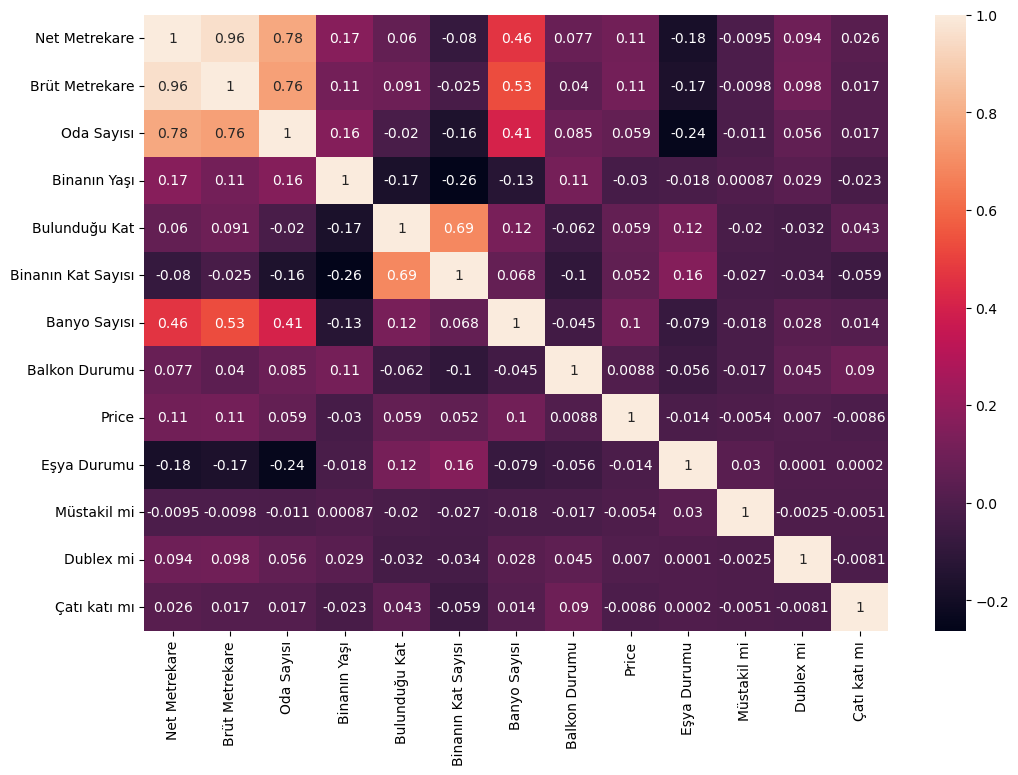

In [43]:
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=True);

### Data Visualization

Önce aykırı değerleri çıkarıyoruz

<Axes: xlabel='Price'>

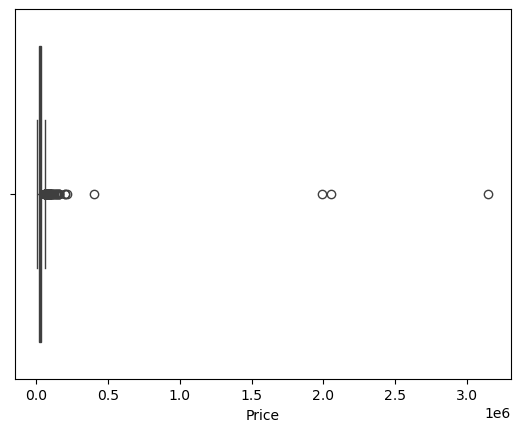

In [49]:
sns.boxplot(x=df["Price"])

In [45]:
df = df[(df["Price"] < 100000)]

<Axes: xlabel='Price'>

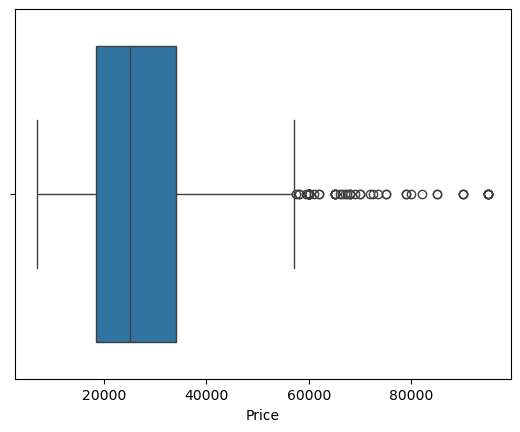

In [47]:
sns.boxplot(x=df["Price"])

<Axes: xlabel='Price', ylabel='Count'>

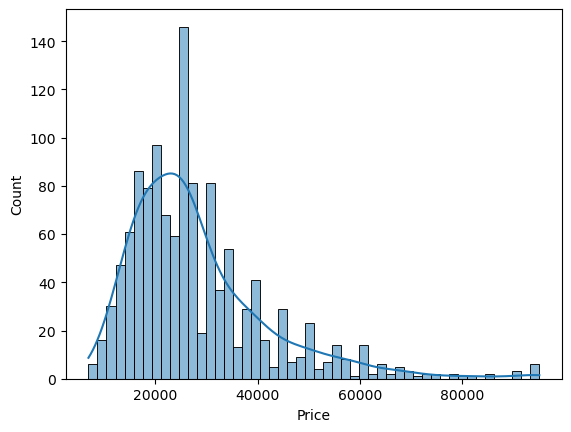

In [55]:
sns.histplot(data=df, x="Price", bins=50, kde=True)

<Axes: xlabel='Net Metrekare', ylabel='Count'>

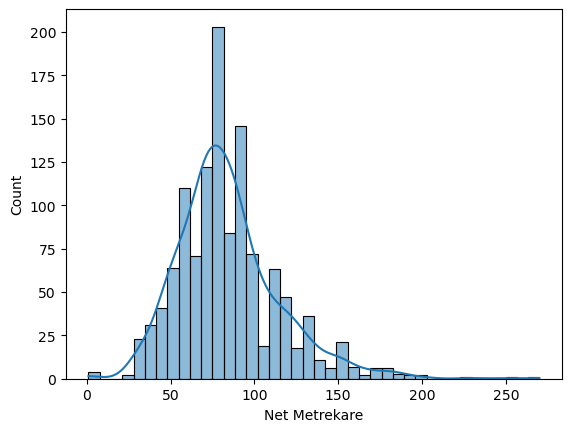

In [57]:
sns.histplot(data=df, x="Net Metrekare", bins=40, kde=True)

Text(0.5, 1.0, 'Oda Sayısına Göre İlan Sayısı')

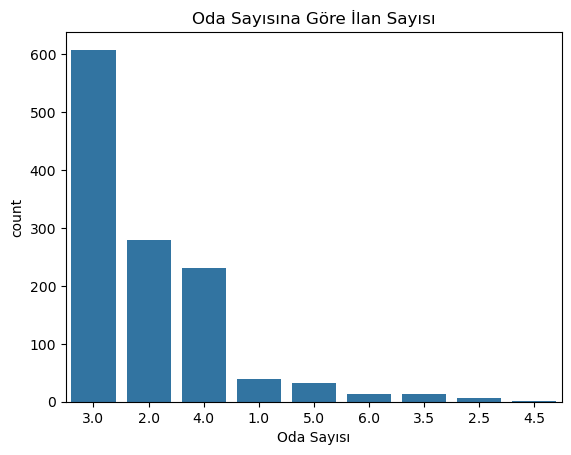

In [59]:
sns.countplot(data=df, x="Oda Sayısı", order=df["Oda Sayısı"].value_counts().index)
plt.title("Oda Sayısına Göre İlan Sayısı")

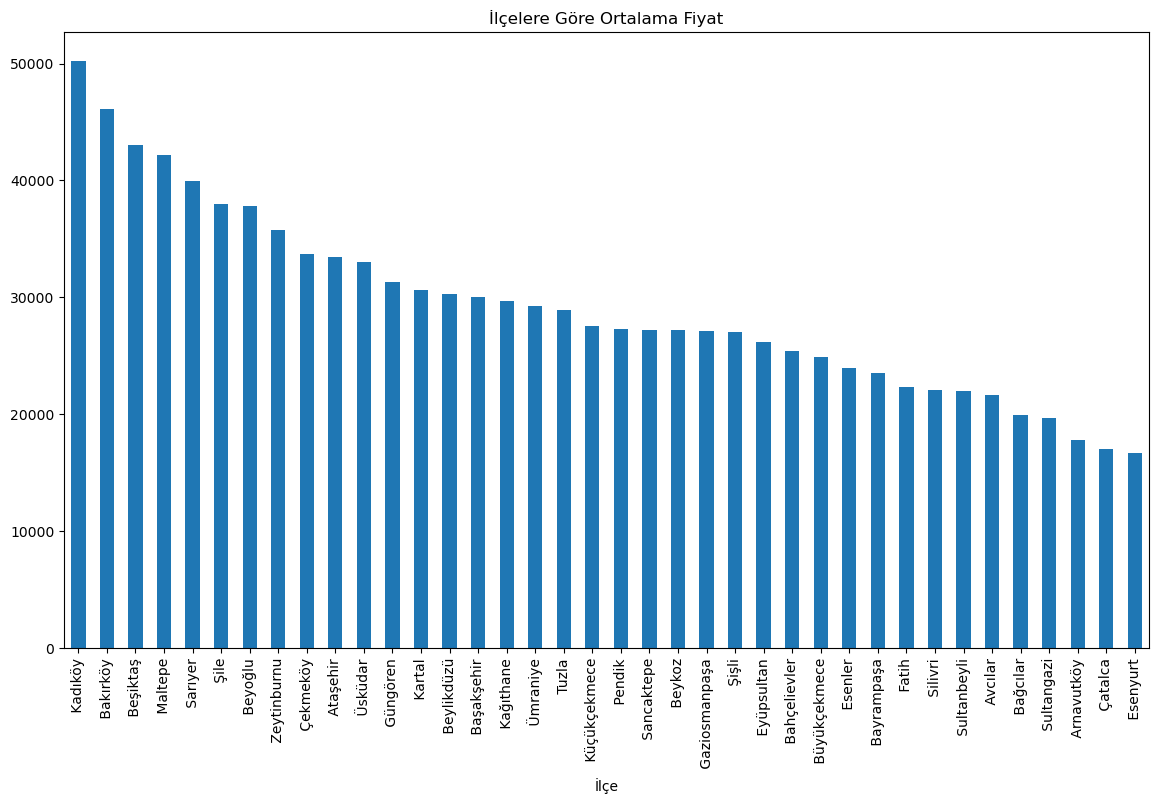

In [61]:
plt.figure(figsize=(14,8))
ilce_avg_price = df.groupby("İlçe")["Price"].mean().sort_values(ascending=False)
ilce_avg_price.plot(kind="bar")
plt.title("İlçelere Göre Ortalama Fiyat");

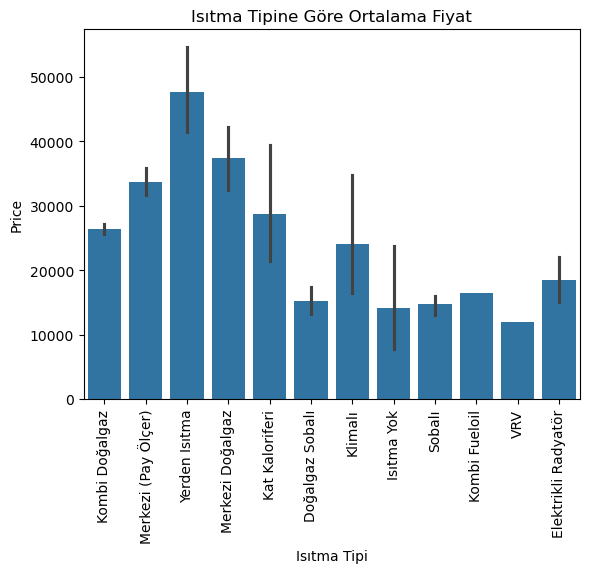

In [63]:
sns.barplot(data=df, x="Isıtma Tipi", y="Price", estimator='mean')
plt.title("Isıtma Tipine Göre Ortalama Fiyat")
plt.xticks(rotation=90);

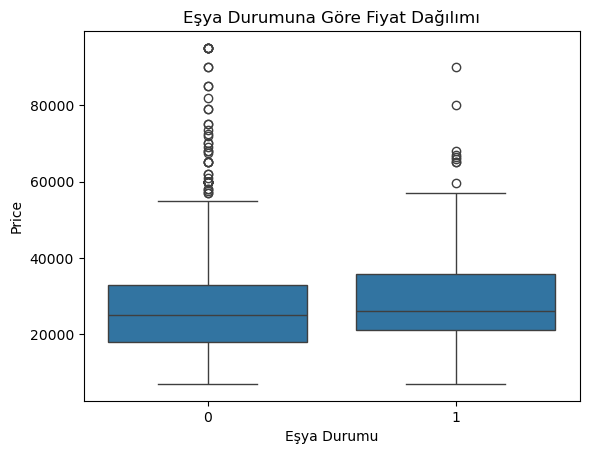

In [65]:
sns.boxplot(data=df, x="Eşya Durumu", y="Price")
plt.title("Eşya Durumuna Göre Fiyat Dağılımı");

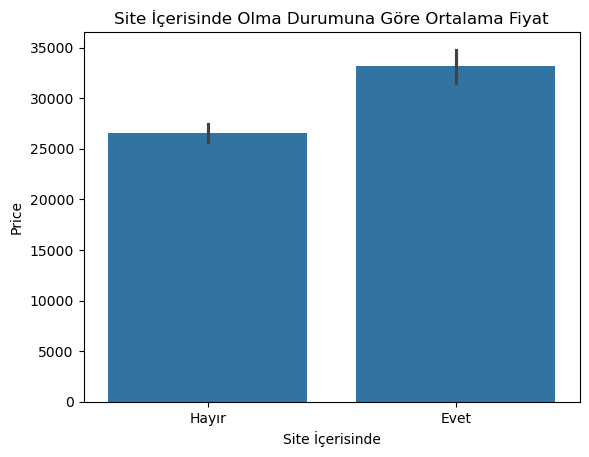

In [67]:
sns.barplot(data=df, x="Site İçerisinde", y="Price", estimator='mean')
plt.title("Site İçerisinde Olma Durumuna Göre Ortalama Fiyat");

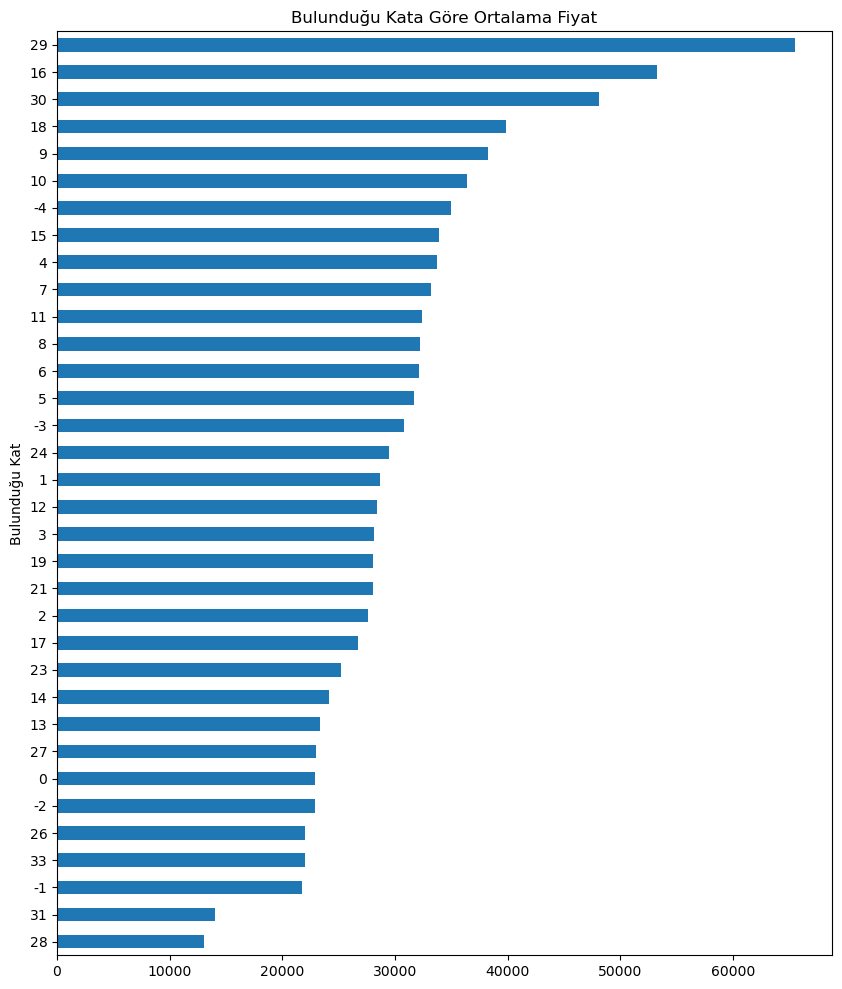

In [69]:
plt.figure(figsize=(10,12))
kat_fiyat = df.groupby("Bulunduğu Kat")["Price"].mean().sort_values()
kat_fiyat.plot(kind='barh')
plt.title("Bulunduğu Kata Göre Ortalama Fiyat");

In [49]:
# aralarında bir hiyerarşi olmadığı için kategoriye çeviriyoruz
df["Bulunduğu Kat"]=df["Bulunduğu Kat"].astype("category")

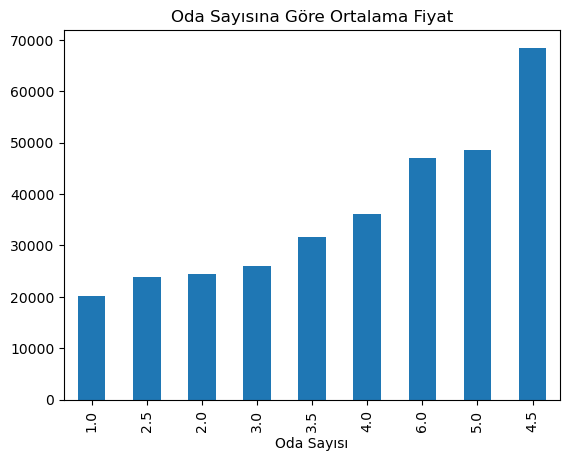

In [75]:
oda_fiyat = df.groupby("Oda Sayısı")["Price"].mean().sort_values()
oda_fiyat.plot(kind="bar")
plt.title("Oda Sayısına Göre Ortalama Fiyat")
plt.xticks(rotation=90);

In [51]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Net Metrekare,1225.0,84.050612,30.636772,1.0,65.0,80.0,100.0,270.0
Brüt Metrekare,1225.0,97.583673,34.121607,30.0,75.0,90.0,115.0,325.0
Oda Sayısı,1225.0,2.986531,0.870743,1.0,2.0,3.0,3.0,6.0
Binanın Yaşı,1225.0,13.324898,9.253188,0.0,7.0,13.0,25.0,25.0
Binanın Kat Sayısı,1225.0,7.096327,6.167636,1.0,4.0,5.0,7.0,60.0
Banyo Sayısı,1225.0,1.185306,0.428685,0.0,1.0,1.0,1.0,4.0
Balkon Durumu,1225.0,0.146939,0.354189,0.0,0.0,0.0,0.0,1.0
Price,1225.0,28341.876735,13991.677071,7000.0,18500.0,25000.0,34000.0,95000.0
Eşya Durumu,1225.0,0.200000,0.400163,0.0,0.0,0.0,0.0,1.0
Müstakil mi,1225.0,0.001633,0.040390,0.0,0.0,0.0,0.0,1.0


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1225 entries, 0 to 1249
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Net Metrekare       1225 non-null   int32   
 1   Brüt Metrekare      1225 non-null   int32   
 2   Oda Sayısı          1225 non-null   float64 
 3   Binanın Yaşı        1225 non-null   int32   
 4   Bulunduğu Kat       1225 non-null   category
 5   Binanın Kat Sayısı  1225 non-null   float64 
 6   Isıtma Tipi         1225 non-null   object  
 7   Kullanım Durumu     1225 non-null   object  
 8   Tapu Durumu         1225 non-null   object  
 9   Site İçerisinde     1225 non-null   object  
 10  Banyo Sayısı        1225 non-null   int32   
 11  Balkon Durumu       1225 non-null   int32   
 12  Fiyat Durumu        1225 non-null   object  
 13  Price               1225 non-null   float64 
 14  Eşya Durumu         1225 non-null   int32   
 15  Müstakil mi         1225 non-null   int32  

In [55]:
df.to_csv('CleanData_istanbulEv.csv', index=False)

In [57]:
numeric_cols = [
    'Net Metrekare',
    'Brüt Metrekare',
    'Oda Sayısı',
    'Binanın Yaşı',
    'Binanın Kat Sayısı',
    'Banyo Sayısı',
    'Balkon Durumu',
    'Price',
    'Eşya Durumu',
    'Müstakil mi',
    'Dublex mi'
]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

In [59]:
# Data Augmentation - Veri Artırma

In [61]:
# Gürültü uygulanacak kolonlar ve noise seviyeleri
noise_settings = {
    'Net Metrekare': 5,         # ±5 m2
    'Binanın Yaşı': 2,          # ±2 yıl
    'Banyo Sayısı': 0.1,        # ±0.1
    'Balkon Durumu': 0.1,       # ±0.1
    'Price': 0.05               # ±%5
}

# Tam sayı olması gereken kolonlar
int_columns = ['Net Metrekare', 'Binanın Yaşı', 'Banyo Sayısı', 'Balkon Durumu']

# Kaç yeni örnek oluşturulacak (her satır için)
n_augments = 2

# Yeni satırları tutacak liste
augmented_rows = []

# Augmentation işlemi
for _, row in df.iterrows():
    for _ in range(n_augments):
        new_row = row.copy()
        for col, noise_level in noise_settings.items():
            original_value = row[col]

            # Eksik veri varsa atla
            if pd.isnull(original_value):
                continue

            # Gürültü üret
            if col == 'Price':
                noise = np.random.normal(0, noise_level * original_value)
            else:
                noise = np.random.normal(0, noise_level)

            new_value = original_value + noise

            # Tam sayıya yuvarla
            if col in int_columns:
                new_value = max(0, int(round(new_value)))  # negatif olmasın

            new_row[col] = new_value

        augmented_rows.append(new_row)

# Yeni veriyi DataFrame'e dönüştür
df_augmented = pd.DataFrame(augmented_rows)

# Ana veri setine ekle
df = pd.concat([df, df_augmented], ignore_index=True)

# Çıktılar
print("Yapay üretilen veri sayısı:", df_augmented.shape[0])
print("Toplam veri sayısı:", df.shape[0])

Yapay üretilen veri sayısı: 2450
Toplam veri sayısı: 3675


### Modelling

In [63]:
x=df.drop("Price", axis=1)
y=df[["Price"]]

In [65]:
x = pd.get_dummies(x, drop_first=True)

In [67]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=.2, random_state=42)

In [69]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

xgb = XGBRegressor(random_state=42)

# GridSearchCV tanımı
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='r2',        
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(x_train, y_train)


print("Best params:", grid_search.best_params_)


best_xgb = grid_search.best_estimator_
xgb_pred = best_xgb.predict(x_test)

# Performans metrikleri
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_r2  = r2_score(y_test, xgb_pred)

print("\n=== XGBRegressor (GridSearchCV) ===")
print(f"MSE: {xgb_mse:.2f}")
print(f"R^2: {xgb_r2:.4f}")

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best params: {'colsample_bytree': 0.8, 'learning_rate': 0.2, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}

=== XGBRegressor (GridSearchCV) ===
MSE: 7361904.88
R^2: 0.9604


In [70]:
import joblib
joblib.dump(best_xgb, "best_xgb_model.pkl")

['best_xgb_model.pkl']

In [71]:
rf = RandomForestRegressor(random_state=42)

# Parametre arama ızgarası
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# GridSearchCV tanımı
grid_search_rf = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    scoring='r2',  # Alternatif: 'neg_mean_squared_error'
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Eğitimi başlat
grid_search_rf.fit(x_train, y_train)

# En iyi modeli al
best_rf = grid_search_rf.best_estimator_

# Test verisinde tahmin
RF_pred = best_rf.predict(x_test)

# Performans metrikleri
RF_mse = mean_squared_error(y_test, RF_pred)
RF_r2 = r2_score(y_test, RF_pred)

# Sonuçları yazdır
print("=== Random Forest (GridSearchCV) ===")
print(f"Best Params: {grid_search_rf.best_params_}")
print(f"MSE : {RF_mse:.2f}")
print(f"R^2 : {RF_r2:.4f}")

Fitting 5 folds for each of 48 candidates, totalling 240 fits
=== Random Forest (GridSearchCV) ===
Best Params: {'bootstrap': True, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
MSE : 9467681.57
R^2 : 0.9491


In [72]:
joblib.dump(best_rf, "best_random_forest_model.pkl")

['best_random_forest_model.pkl']

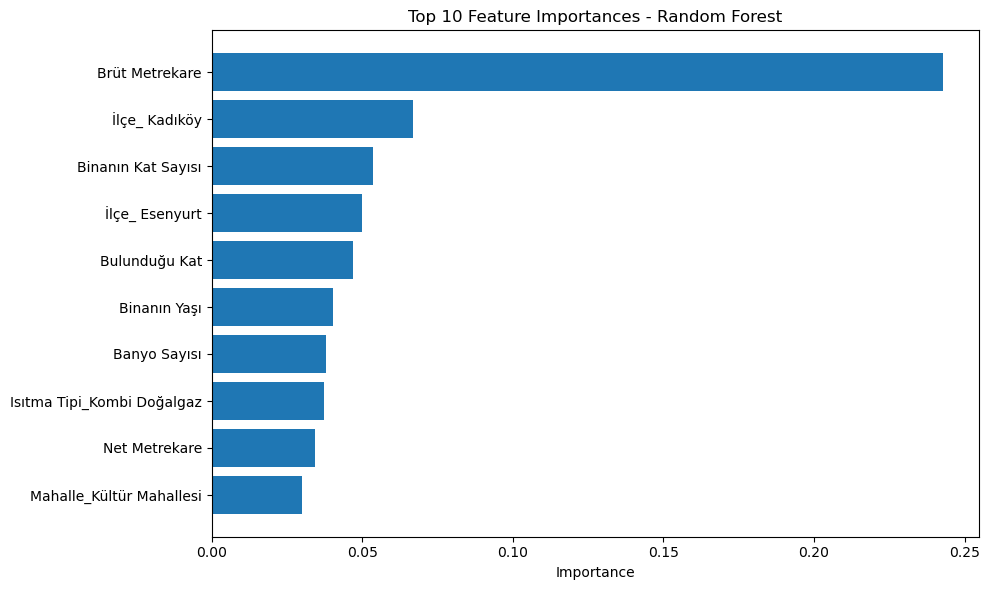

In [77]:
# Özellik önem derecelerini al
importances = best_rf.feature_importances_

# Özellik isimlerini al
feature_names = x_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'][:10][::-1], 
         feature_importance_df['Importance'][:10][::-1])
plt.xlabel("Importance")
plt.title("Top 10 Feature Importances - Random Forest")
plt.tight_layout()
plt.show()